# GEOG696C Spatiotemporal Data Analysis
## Homework #5b: Maximum Covariance Analaysis (MCA)
Alex Saunders | Last updated: 31 October 2023

In [1]:
from pathlib import Path
import os
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt, colors
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patheffects as pe
from datetime import datetime
import calendar
import scipy as sp
import xarray as xr
import cartopy
import cartopy.crs as ccrs 
import cartopy.feature as cfeature

In [2]:
# Set the root path
rootPath = Path('C:/Users/alexa/Documents/GitHub/spatiotemporal_data_analysis/00_hw')
dataPath = Path ('C:/Users/alexa/Documents/01_personal/07_phd/05_study/02_courses/2023/1/GEOG696/data')

## 2. Read the HadISST data and 500mb heights data

### HadISST

In [3]:
sst = xr.open_dataset(dataPath/'HadISST_sst.nc')
sst = sst.sst

In [4]:
sst

<xarray.DataArray 'sst' (time: 1840, latitude: 180, longitude: 360)>
[119232000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2023-0...
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

### 500mb height from 20th century reanalysis

In [5]:
hgt=xr.open_dataset(dataPath/'hgt_500mb_mon_mean.nc')
hgt=hgt.hgt
hgt = hgt.squeeze(drop=True) 

## 3. Preprocess the datasets
Create Nov-March mean values, and account for missing data locations and the target domain

### Prepare SST data

In [6]:
# Set missing values to na
sst = sst.where(sst>=0, np.nan)

# Transform the coord system from -180to180 longitude, to 0to360 degrees
sst = sst.assign_coords(longitude=(sst.longitude % 360))
sst = sst.sortby(sst.longitude)

# Specify the desired area, and find corresponding start and end lat/lons that are present in the data
lons=[120, 260]
lats=[60, -20]
sst = sst.sel(longitude=slice(lons[0], lons[1]), latitude=slice(lats[0], lats[1]))

# Extract coordinates
lat = sst.latitude
lon = sst.longitude

# We use the rolling mean technique, with window of 5 months, taking only the ones ending in March
sstRolling = sst.rolling(time = 5).mean(skipna=True)
endMo=3
sstSeasonal = sstRolling[sstRolling.time.dt.month==endMo]

# Drop the first which is an incomplete year
sstSeasonal = sstSeasonal.drop_isel(time=[0])

In [7]:
# Convert to np array for reshaping
ntime, nlat, nlon = sstSeasonal.shape
print(sstSeasonal.shape)
sstMat = np.array(sstSeasonal).reshape(ntime, nlat*nlon, order='F')
print(sstMat.shape)

# Drop locations wtih missing values
sstMatComplete = sstMat[:, ~np.isnan(sstMat).any(axis=0)]
print(sstMatComplete.shape)

# # Get the mean and subtract it from the yearly seasonal average values, at ech location
# sstAnom = sstMatComplete - sstMatComplete.mean(axis=0)

(153, 80, 140)
(153, 11200)
(153, 9329)


In [8]:
# Get the mean and reshape to original size
sstMatOrig=np.array(sstSeasonal).reshape(ntime, nlat*nlon, order='F')
missingLocs = ~np.isnan(sstMatOrig).any(axis=0)
sstMean = np.zeros([nlat*nlon]) * np.nan # 2D
sstMeanComplete =sstMatComplete.mean(axis=0)
sstMean[missingLocs] = sstMeanComplete
sstMean = sstMean.reshape([nlat, nlon], order='F')
print(sstMean.shape)

(80, 140)


### Prepare 500mb height data

In [9]:
# We use the rolling mean technique, with window of 5 months, taking only the ones ending in March
hgtRolling = hgt.rolling(time = 5).mean(skipna=True)

# Select March to get the average over NDJFM
endMo=3
hgtSeasonal = hgtRolling[hgtRolling.time.dt.month==endMo]

# Drop the first which is an incomplete year
hgtSeasonal= hgtSeasonal.drop_isel(time=[0])

In [10]:
hgtMean = hgtSeasonal.mean(dim='time')

## 4. Plot a map of the long term mean of both data

In [11]:
sstMean.shape

(80, 140)

In [12]:
hgtMean.shape

(181, 360)

### Plot of the long term mean SST

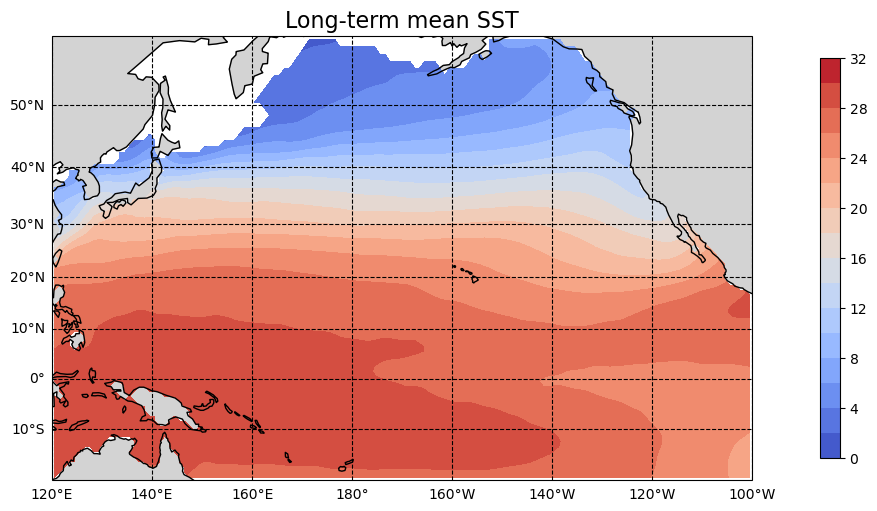

In [13]:
fig, ax = plt.subplots(figsize=(10,5), clear=True, constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=260)})

# specifying the levels gives us more control on the map
levels = np.linspace(0, 32, 17)

ax.set_title('Long-term mean SST', fontsize=16)
ax.coastlines(color="black") 
ax.add_feature(cfeature.LAND, color='lightgray')
ax.set_extent([lons[0], lons[1], lats[1], lats[0]], crs=ccrs.PlateCarree())
gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                  y_inline=False, ylocs=[-10, 0, 10, 20, 30, 40, 50, 60], xlocs=[120, 140, 160, 180, -160, -140, -120, -100])
plt1 = ax.contourf(lon, lat, sstMean, cmap='coolwarm', transform=ccrs.PlateCarree(), levels=levels)# vmin=-0.05, vmax=0.05, transform=ccrs.PlateCarree()) 
cb1 = plt.colorbar(plt1, orientation='vertical', shrink=0.9, ticks=np.linspace(0, 32, 9))
ax.set_aspect('equal')
plt.show()

### Plot of the long term mean 500mb height

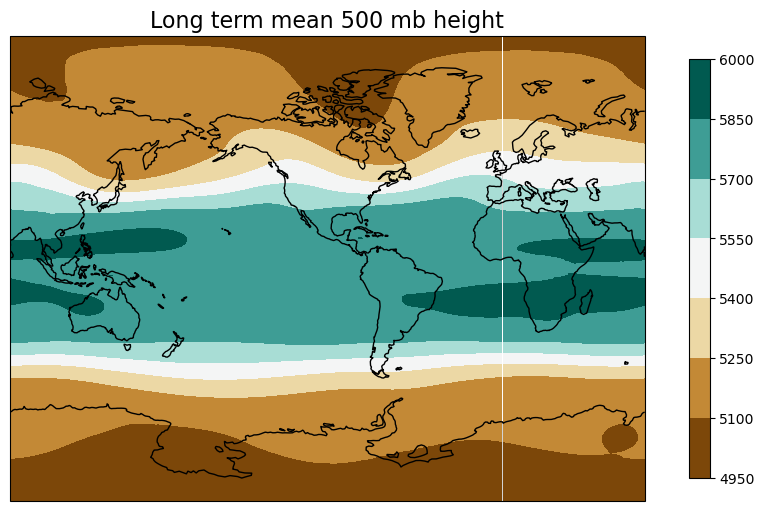

In [14]:
# levels = np.linspace(-80, 50, 21)

fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=260)}) #subplot_kw={'projection': ccrs.Stereographic()})

ax.set_title('Long term mean 500 mb height', fontsize=16)
ax.coastlines(color="black") 
ax.add_feature(cfeature.LAND, color='lightgray')
plt1 = ax.contourf(hgtMean.lon, hgtMean.lat, hgtMean.values, cmap='BrBG', transform=ccrs.PlateCarree())#, levels=levels, vmin=-80, vmax=50) 
cb1 = plt.colorbar(plt1, orientation='vertical', shrink=0.9)#, ticks=np.linspace(-80, 50, 11))

ax.set_aspect('equal')

plt.show()

## 5. Isolate the years the two datasets have in common

In [15]:
# Standardize the time attribute of each dataset and find indices of corresponding years
hgtTime = np.array(hgtSeasonal.time)
hgtTime = [pd.to_datetime(str(pd.to_datetime(item).year)+'-01-01') for item in hgtTime]

In [16]:
sstTime = np.array(sstSeasonal.time)
sstTime = [pd.to_datetime(str(pd.to_datetime(item).year)+'-01-01') for item in sstTime]

In [17]:
commonTime = pd.DataFrame(hgtTime).merge(pd.DataFrame(sstTime), how='inner')

In [18]:
# Isolate to common years
hgtInt = hgtSeasonal.copy()
hgtInt['time']= hgtTime
hgtInt=hgtInt[hgtInt.time.isin(commonTime)]

In [19]:
sstSeasonalCopy=sstSeasonal.copy()
sstSeasonalCopy['time']=sstTime
sstIndices = np.where(sstSeasonalCopy.time.isin(commonTime))[0]
sstInt = sstMatComplete[sstIndices, :]

In [20]:
# Now they have the same time period
print(sstInt.shape[0], len(hgtInt.time))

145 145


## 6. Perform MCA on the two fields using SVD

### Center and normalize

In [21]:
# Center and normalize the data - now these are both z
hgtNorm = (hgtInt - hgtInt.mean(axis=0)) / hgtInt.std(axis=0)

In [22]:
sstNorm = (sstInt - sstInt.mean(axis=0)) / sstInt.std(axis=0)

### Reshape

In [23]:
# Reshape from ntime*nlat*nlon to ntime*nlocs
ntime, nlat, nlon = hgtNorm.shape
hgtNorm = np.array(hgtNorm).reshape(ntime, nlat*nlon, order='F')

In [24]:
# ntime, nlat, nlon = sstNorm.shape
# sstNormReshape = np.array(sstNorm).reshape(ntime, nlat*nlon, order='F')

In [25]:
print(hgtNorm.shape)
print(hgtNorm.T.shape)
print(sstNorm.shape)

(145, 65160)
(65160, 145)
(145, 9329)


### Create covariance and perform SVD

In [26]:
# Construct cross-covariance matrix
m=hgtNorm.shape[0]
C = (hgtNorm.T @ sstNorm)/(m-1)

In [27]:
print(C.shape)

(65160, 9329)


In [28]:
# Perform SVD on the non-square, non-symmetrical cross-covariance matrix
# U, s, Vt = np.linalg.svd(C, full_matrices=False)
U, s, Vt = sp.sparse.linalg.svds(C, k=3)

In [48]:
sort_index = np.argsort(s)[::-1] # sort L in descending order from high to low to rank the modes
s = s[sort_index] # apply the index
U = U[:,sort_index] # apply the index
Vt = Vt[sort_index,:] # apply the index

U is the eigenvectors associated with hgt and V is the eigenvectors associated with sst

### Construct the signals (PCs) by multiplying the original fields with the eigen vectors

In [49]:
hgtPC = hgtNorm @ U
sstPC = sstNorm @ Vt.T

### Get the squared covaraince fraction (scf)

In [50]:
scf = (s**2)/sum(s**2)

In [51]:
print(hgtPC.shape)
print(sstPC.shape)

(145, 3)
(145, 3)


In [52]:
scf

array([0.7901963 , 0.18816693, 0.02163674], dtype=float32)

## 9. Calculate the simple correlation between the first 3 pairs of PCs

In [53]:
rvals=[]
pvals=[]
for i in range(3):
    r, p = sp.stats.pearsonr(hgtPC[:,i], sstPC[:,i])
    rvals.append(r)
    pvals.append(p)

In [54]:
rvals, pvals

([0.8801195173289421, 0.7522127123660207, 0.6421632002422529],
 [4.100913982109022e-48, 1.0914685041239093e-27, 3.1801097174365163e-18])

__WHat do we see?__ We observe a strong positive correlation between the three leading modes of the SST and 500mb height datasets

## 8. Calculate and plot the homegeneous and heterogenous correlations between the leading 3 signals from both datasets and the original data using simple correlations

In [60]:
hgt_array = xr.DataArray(hgtPC, coords={'time': hgtInt.time, 'mode': np.arange(0,3)}, dims=["time","mode"],name="hgtPC")
sst_array = xr.DataArray(sstPC, coords={'time': sstSeasonalCopy[sstSeasonalCopy.time.isin(commonTime)].time, 'mode': np.arange(0,3)}, dims=["time","mode"],name="sstPC")

In [69]:
hgtSeasonalCopy=hgtSeasonal.copy()
hgtSeasonalCopy['time']=hgtTime

In [84]:
hgt_homogenous_correlation = xr.corr(hgt_array,hgtSeasonalCopy,dim="time")
sst_homogenous_correlation = xr.corr(sst_array,sstSeasonalCopy,dim="time")

hgt_heterogenous_correlation = xr.corr(hgt_array,sstSeasonalCopy,dim="time")
sst_heterogenous_correlation = xr.corr(sst_array,hgtSeasonalCopy,dim="time")

C:\Users\alexa\anaconda3\envs\spatiotemp3\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\alexa\anaconda3\envs\spatiotemp3\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\alexa\anaconda3\envs\spatiotemp3\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\alexa\anaconda3\envs\spatiotemp3\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


### Homogeneous correlations

C:\Users\alexa\anaconda3\envs\spatiotemp3\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
C:\Users\alexa\anaconda3\envs\spatiotemp3\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
C:\Users\alexa\anaconda3\envs\spatiotemp3\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


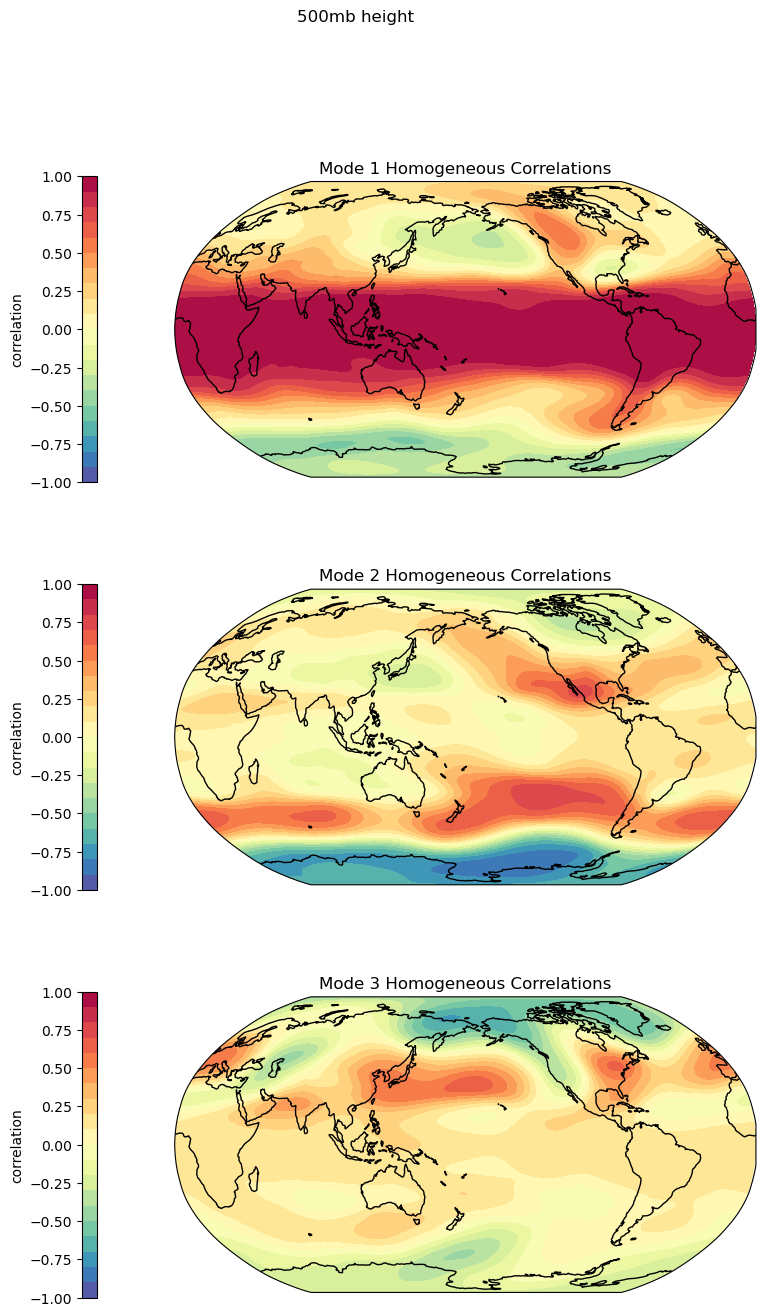

In [81]:
# plot the Homogeneous correlation field
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(10,15), clear=True,nrows=3,ncols=1,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
fig.suptitle('500mb height')
# specifying the levels gives us more control on the map
levels = np.linspace(-1, 1, 21)

nox1 = ax1.contourf(hgt.lon,hgt.lat,hgt_homogenous_correlation[0,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
# mox1 = ax1.contourf(sst.longitude,sst.latitude,sst_homogenous_correlation[0,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
# ax1.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax1.coastlines()  # we can pass arguments to .coastlines function
# ax1.add_feature(cfeature.LAND, color='black')
ax1.set_title('Mode 1 Homogeneous Correlations', fontsize=12)
cb1 = plt.colorbar(nox1, orientation='vertical',location='left',shrink=0.9,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb1.set_label('correlation', fontsize=10) 

nox2 = ax2.contourf(hgt.lon,hgt.lat,hgt_homogenous_correlation[1,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
# mox2 = ax2.contourf(sst.longitude,sst.latitude,sst_homogenous_correlation[1,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())

# ax2.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax2.coastlines()  # we can pass arguments to .coastlines function
# ax2.add_feature(cfeature.LAND, color='black')
ax2.set_title('Mode 2 Homogeneous Correlations', fontsize=12)
cb2 = plt.colorbar(nox2, orientation='vertical',location='left',shrink=0.9,extend='both',ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb2.set_label('correlation', fontsize=10) 

nox3 = ax3.contourf(hgt.lon,hgt.lat,hgt_homogenous_correlation[2,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
# mox2 = ax2.contourf(sst.longitude,sst.latitude,sst_homogenous_correlation[1,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())

# ax2.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax3.coastlines()  # we can pass arguments to .coastlines function
# ax2.add_feature(cfeature.LAND, color='black')
ax3.set_title('Mode 3 Homogeneous Correlations', fontsize=12)
cb3 = plt.colorbar(nox3, orientation='vertical',location='left',shrink=0.9,extend='both',ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb3.set_label('correlation', fontsize=10) 

C:\Users\alexa\anaconda3\envs\spatiotemp3\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
C:\Users\alexa\anaconda3\envs\spatiotemp3\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
C:\Users\alexa\anaconda3\envs\spatiotemp3\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


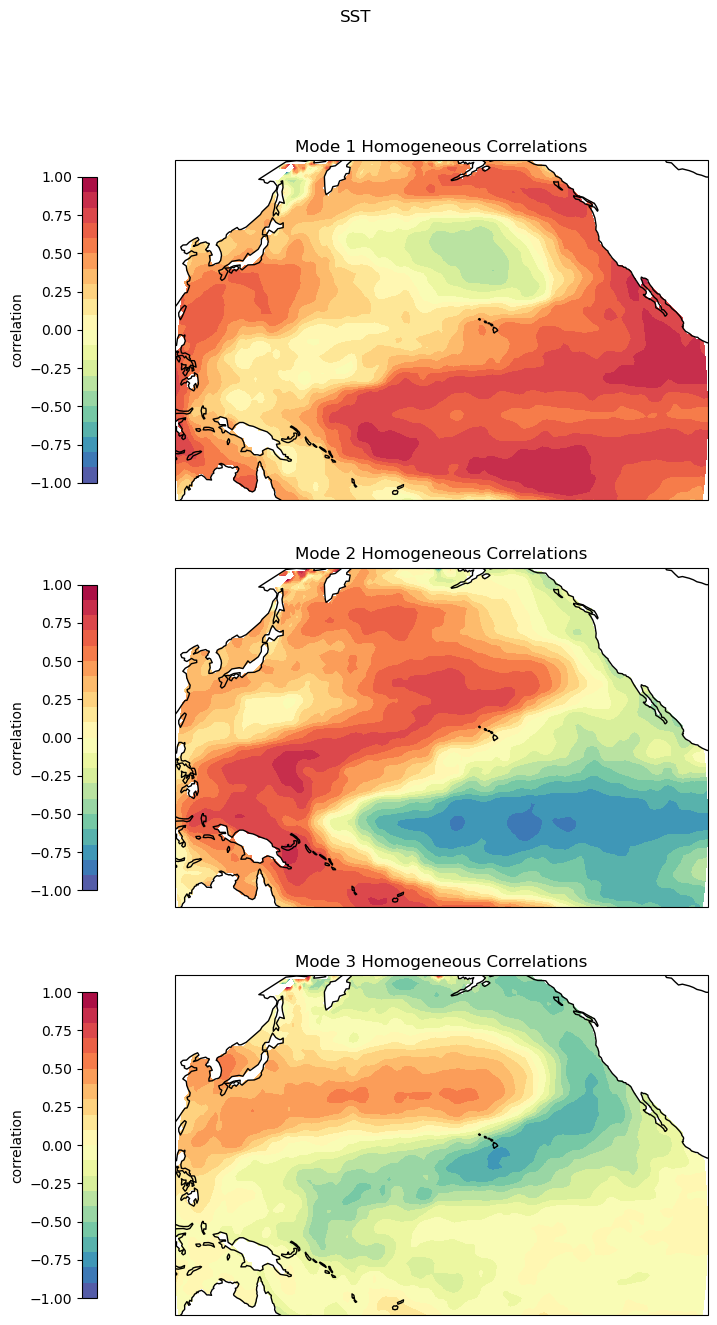

In [82]:
# plot the Homogeneous correlation field
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(10,15), clear=True,nrows=3,ncols=1,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
fig.suptitle('SST')
# specifying the levels gives us more control on the map
levels = np.linspace(-1, 1, 21)

nox1 = ax1.contourf(sst.longitude,sst.latitude,sst_homogenous_correlation[0,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
# mox1 = ax1.contourf(sst.longitude,sst.latitude,sst_homogenous_correlation[0,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
# ax1.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax1.coastlines()  # we can pass arguments to .coastlines function
# ax1.add_feature(cfeature.LAND, color='black')
ax1.set_title('Mode 1 Homogeneous Correlations', fontsize=12)
cb1 = plt.colorbar(nox1, orientation='vertical',location='left',shrink=0.9,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb1.set_label('correlation', fontsize=10) 

nox2 = ax2.contourf(sst.longitude,sst.latitude,sst_homogenous_correlation[1,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
# mox2 = ax2.contourf(sst.longitude,sst.latitude,sst_homogenous_correlation[1,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())

# ax2.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax2.coastlines()  # we can pass arguments to .coastlines function
# ax2.add_feature(cfeature.LAND, color='black')
ax2.set_title('Mode 2 Homogeneous Correlations', fontsize=12)
cb2 = plt.colorbar(nox2, orientation='vertical',location='left',shrink=0.9,extend='both',ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb2.set_label('correlation', fontsize=10) 

nox3 = ax3.contourf(sst.longitude,sst.latitude,sst_homogenous_correlation[2,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
# mox2 = ax2.contourf(sst.longitude,sst.latitude,sst_homogenous_correlation[1,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())

# ax2.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax3.coastlines()  # we can pass arguments to .coastlines function
# ax2.add_feature(cfeature.LAND, color='black')
ax3.set_title('Mode 3 Homogeneous Correlations', fontsize=12)
cb3 = plt.colorbar(nox3, orientation='vertical',location='left',shrink=0.9,extend='both',ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb3.set_label('correlation', fontsize=10) 

### Heterogenous correlations

C:\Users\alexa\anaconda3\envs\spatiotemp3\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
C:\Users\alexa\anaconda3\envs\spatiotemp3\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
C:\Users\alexa\anaconda3\envs\spatiotemp3\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


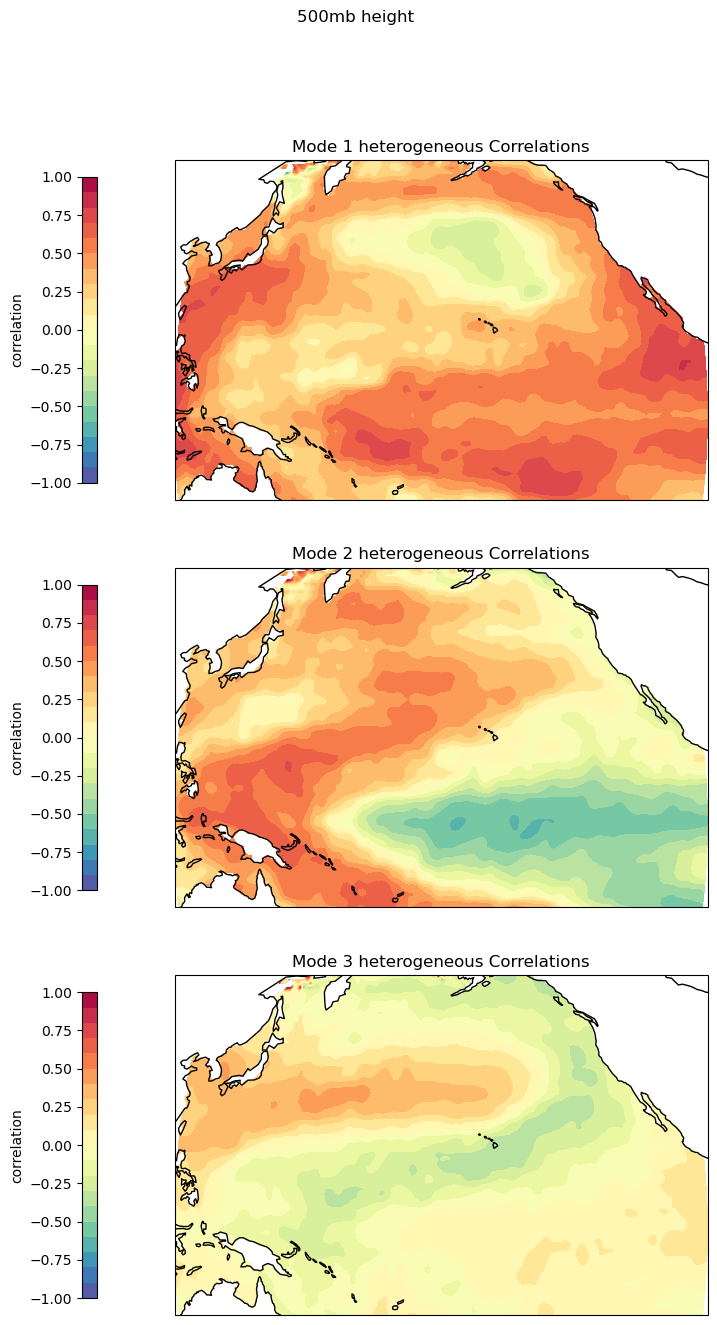

In [87]:
# plot the heterogeneous correlation field
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(10,15), clear=True,nrows=3,ncols=1,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
fig.suptitle('500mb height')
# specifying the levels gives us more control on the map
levels = np.linspace(-1, 1, 21)

nox1 = ax1.contourf(sst.longitude,sst.latitude,hgt_heterogenous_correlation[0,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
# mox1 = ax1.contourf(sst.longitude,sst.latitude,sst_heterogenous_correlation[0,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
# ax1.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax1.coastlines()  # we can pass arguments to .coastlines function
# ax1.add_feature(cfeature.LAND, color='black')
ax1.set_title('Mode 1 heterogeneous Correlations', fontsize=12)
cb1 = plt.colorbar(nox1, orientation='vertical',location='left',shrink=0.9,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb1.set_label('correlation', fontsize=10) 

nox2 = ax2.contourf(sst.longitude,sst.latitude,hgt_heterogenous_correlation[1,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
# mox2 = ax2.contourf(sst.longitude,sst.latitude,sst_heterogenous_correlation[1,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())

# ax2.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax2.coastlines()  # we can pass arguments to .coastlines function
# ax2.add_feature(cfeature.LAND, color='black')
ax2.set_title('Mode 2 heterogeneous Correlations', fontsize=12)
cb2 = plt.colorbar(nox2, orientation='vertical',location='left',shrink=0.9,extend='both',ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb2.set_label('correlation', fontsize=10) 

nox3 = ax3.contourf(sst.longitude,sst.latitude,hgt_heterogenous_correlation[2,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
# mox2 = ax2.contourf(sst.longitude,sst.latitude,sst_heterogenous_correlation[1,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())

# ax2.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax3.coastlines()  # we can pass arguments to .coastlines function
# ax2.add_feature(cfeature.LAND, color='black')
ax3.set_title('Mode 3 heterogeneous Correlations', fontsize=12)
cb3 = plt.colorbar(nox3, orientation='vertical',location='left',shrink=0.9,extend='both',ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb3.set_label('correlation', fontsize=10) 

C:\Users\alexa\anaconda3\envs\spatiotemp3\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
C:\Users\alexa\anaconda3\envs\spatiotemp3\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
C:\Users\alexa\anaconda3\envs\spatiotemp3\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


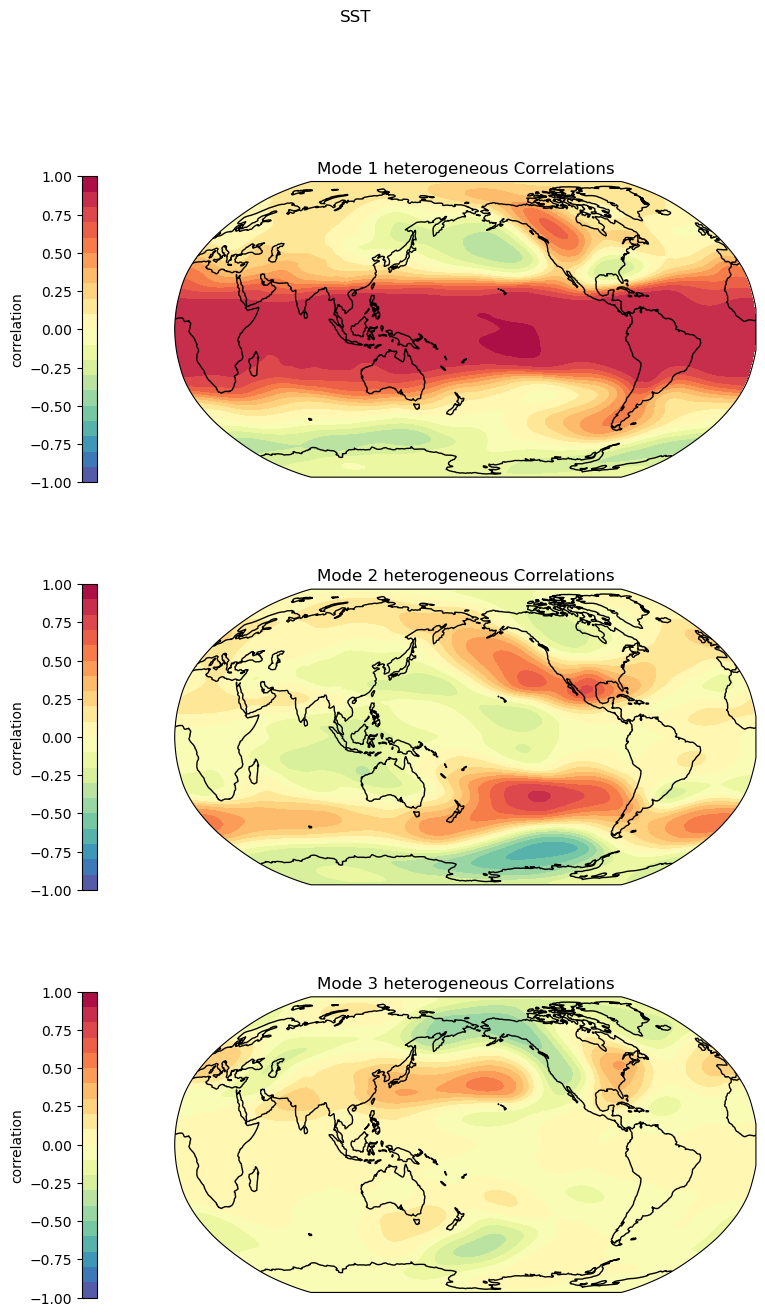

In [88]:
# plot the heterogeneous correlation field
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(10,15), clear=True,nrows=3,ncols=1,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
fig.suptitle('SST')
# specifying the levels gives us more control on the map
levels = np.linspace(-1, 1, 21)

nox1 = ax1.contourf(hgt.lon,hgt.lat,sst_heterogenous_correlation[0,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
# mox1 = ax1.contourf(sst.longitude,sst.latitude,sst_heterogenous_correlation[0,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
# ax1.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax1.coastlines()  # we can pass arguments to .coastlines function
# ax1.add_feature(cfeature.LAND, color='black')
ax1.set_title('Mode 1 heterogeneous Correlations', fontsize=12)
cb1 = plt.colorbar(nox1, orientation='vertical',location='left',shrink=0.9,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb1.set_label('correlation', fontsize=10) 

nox2 = ax2.contourf(hgt.lon,hgt.lat,sst_heterogenous_correlation[1,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
# mox2 = ax2.contourf(sst.longitude,sst.latitude,sst_heterogenous_correlation[1,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())

# ax2.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax2.coastlines()  # we can pass arguments to .coastlines function
# ax2.add_feature(cfeature.LAND, color='black')
ax2.set_title('Mode 2 heterogeneous Correlations', fontsize=12)
cb2 = plt.colorbar(nox2, orientation='vertical',location='left',shrink=0.9,extend='both',ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb2.set_label('correlation', fontsize=10) 

nox3 = ax3.contourf(hgt.lon,hgt.lat,sst_heterogenous_correlation[2,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
# mox2 = ax2.contourf(sst.longitude,sst.latitude,sst_heterogenous_correlation[1,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())

# ax2.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax3.coastlines()  # we can pass arguments to .coastlines function
# ax2.add_feature(cfeature.LAND, color='black')
ax3.set_title('Mode 3 heterogeneous Correlations', fontsize=12)
cb3 = plt.colorbar(nox3, orientation='vertical',location='left',shrink=0.9,extend='both',ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb3.set_label('correlation', fontsize=10) 